In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [122]:
class Model(nn.Module):
  # Input layer with all of the features
  def __init__(self, in_features=13, h1=18, h2=16, out_features=3):
        # in_features needs to be 13, matching input data
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1, h2)
        self.output = nn.Linear(h2, out_features)


  # Forward propagation
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.output(x)
    return x


In [106]:
torch.manual_seed(101)
model = Model()

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [108]:
url = 'https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/refs/heads/master/Datasets/wine.data.csv'
df = pd.read_csv(url)
df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [109]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [110]:
X = X.values
y = y.values

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [112]:
y_train = y_train - 1
y_test = y_test - 1
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [113]:
# Measure Error
criterion = nn.CrossEntropyLoss()
# Optimizer for learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [119]:
# Train Model
epochs = 500
losses = []
for i in range(epochs):
  # Prediction
  y_pred = model.forward(X_train)
  # Prediction vs Actual in Training
  loss = criterion(y_pred, y_train)
  # Keeping Track of Losses
  losses.append(loss.detach().numpy())
  print(f'Epoch: {i} Loss: {loss}')
  scheduler.step(loss)

  if i % 10 == 0:
    #with torch.no_grad():
      #y_val = model.forward(X_test)
      #loss = criterion(y_val, y_test)
    print(f'Epoch: {i} Validation Loss: {loss}')

  # Backpropagation: If there is an error, give it back to the NN, which uses it to tweak weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 Loss: 0.0581180602312088
Epoch: 0 Validation Loss: 0.0581180602312088
Epoch: 1 Loss: 0.05799347907304764
Epoch: 2 Loss: 0.057869091629981995
Epoch: 3 Loss: 0.057745032012462616
Epoch: 4 Loss: 0.057621102780103683
Epoch: 5 Loss: 0.057497408241033554
Epoch: 6 Loss: 0.0573737807571888
Epoch: 7 Loss: 0.05725056678056717
Epoch: 8 Loss: 0.05712730064988136
Epoch: 9 Loss: 0.05700443312525749
Epoch: 10 Loss: 0.056881677359342575
Epoch: 10 Validation Loss: 0.056881677359342575
Epoch: 11 Loss: 0.05675908178091049
Epoch: 12 Loss: 0.05663663521409035
Epoch: 13 Loss: 0.056514378637075424
Epoch: 14 Loss: 0.05639221891760826
Epoch: 15 Loss: 0.056270234286785126
Epoch: 16 Loss: 0.05614910274744034
Epoch: 17 Loss: 0.056028179824352264
Epoch: 18 Loss: 0.055906519293785095
Epoch: 19 Loss: 0.055785007774829865
Epoch: 20 Loss: 0.05566377192735672
Epoch: 20 Validation Loss: 0.05566377192735672
Epoch: 21 Loss: 0.055543091148138046
Epoch: 22 Loss: 0.055422279983758926
Epoch: 23 Loss: 0.05530214309692

Text(0, 0.5, 'Loss')

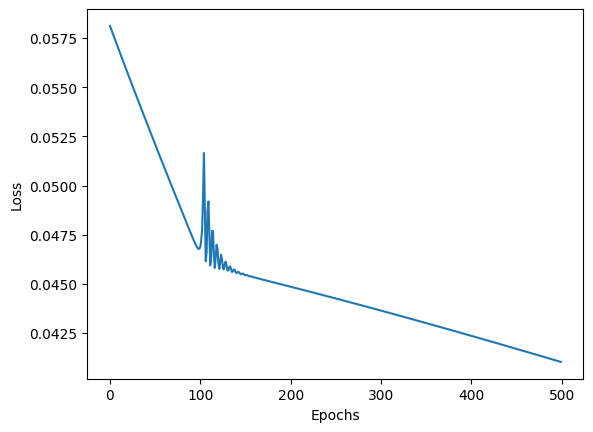

In [120]:
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [121]:
# Evaluate model on test set + get rid of backprop because we've already trained weights
with torch.no_grad():
  y_val = model.forward(X_test)
  loss = criterion(y_val, y_test)
print(loss)

tensor(0.1480)


In [129]:
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val =  model.forward(data)
    print(f'{i+1:2}. {str(y_val):38} {X}')

    if y_test[i] == 0:
      X = 'Wine1'
    elif y_test[i] == 1:
      X = 'Wine2'
    else:
      X = 'Wine3'

    if y_val.argmax().item() == y_test[i]:
      correct += 1

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([ -2.4239,  -9.4900, -11.2058]) Wine1
 2. tensor([ -2.4523,  -6.1648, -12.3746]) Wine1
 3. tensor([-7.9802, -9.3214,  2.2712])    Wine1
 4. tensor([  0.3436, -10.9617, -12.1964]) Wine3
 5. tensor([ -8.2665, -10.7899,   4.0954]) Wine1
 6. tensor([-6.4482, -0.9121, -4.8542])    Wine3
 7. tensor([ -8.6374, -10.2455,   1.6287]) Wine2
 8. tensor([ -0.3738, -13.7171, -12.8336]) Wine3
 9. tensor([ -2.3389,   0.6917, -13.2584]) Wine1
10. tensor([ -1.4697,  -0.8758, -12.0770]) Wine2
11. tensor([ -1.2458, -16.6187, -12.8621]) Wine2
12. tensor([-3.5670, -2.7437, -8.8135])    Wine1
13. tensor([-3.1530, -5.1541, -7.1118])    Wine2
14. tensor([ -1.9041,  -9.4127, -10.4889]) Wine1
15. tensor([-2.1091, -7.9174, -7.1810])    Wine1
16. tensor([ -1.8461, -15.1235, -11.3160]) Wine1
17. tensor([ -4.3470,   2.1992, -10.6750]) Wine1
18. tensor([-8.6616, -2.4162, -1.6016])    Wine2
19. tensor([ -5.4801,   2.5884, -11.1592]) Wine3
20. tensor([ -4.6254,   2.6881, -11.9901]) Wine2
21. tensor([-7.1210,